In [3]:
! pip3 install --upgrade emcee corner pytorch-lightning tqdm nflows scipy zuko astropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.3/329.3 kB 7.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.3.3
    Uninstalling pytorch-lightning-2.3.3:
      Successfully uninstalled pytorch-lightning-2.3.3

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
import zuko

# Simulation-based (likelihood-free) inference
Originally by **Siddharth Mishra-Sharma**.
Updated by **Jessie Micallef** ([jessiem@mit.edu](mailto:jessiem@mit.edu))

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jessimic/sbi-tutorial/blob/main/Tutorial2_2DInput_NPE_Coverage.ipynb)

# 1. Introduction for Tutorial 2 

This notebook will use an example of 2D images now as input with a more practicle example of SBI in use. This tutorial will...

- Setup NPE with new dataset
- Discuss assessing uncertanties
- Explore robustness to adviserial attack

## 1.1 A more complicated example: distribution of point sources in a 2D image

Finally, let's look at a more complicated example, one that is closer to a typical application of SBI and where the likelihood is formally intractable.

The forward model simulates a map of point sources with mean counts drawn from a power law (Pareto) distribution. The distribution of the mean counts is given by the following equation:

$$
\frac{\mathrm dn}{\mathrm  ds} = A s^{\beta}
$$

where $A$ is the amplitude (amp_b), $s$ is the flux, and $\beta$ is the exponent (exp_b). The fluxes are drawn from a truncated power law with minimum and maximum bounds, $s_\text{min}$ and $s_\text{max}$, respectively.

The number of sources is determined by integrating the power law distribution within the flux limits and taking a Poisson realization:

$$
N_\text{sources} \sim \text{Pois}\left(\int_{s_\text{min}}^{s_\text{max}} \, \mathrm ds \frac{\mathrm dn}{\mathrm ds}\right)
$$

For each source, a position is randomly assigned within the box of size `box_size`. The fluxes are then binned into a grid with `resolution` number of bins in both x and y directions. The resulting map is convolved with a Gaussian point spread function (PSF) with a standard deviation of `sigma_psf` to account for the spatial resolution of the instrument.

The output is a 2D map of counts, representing the simulated observation of the point sources in the sky.

Text(0, 0.5, 'Pixels')

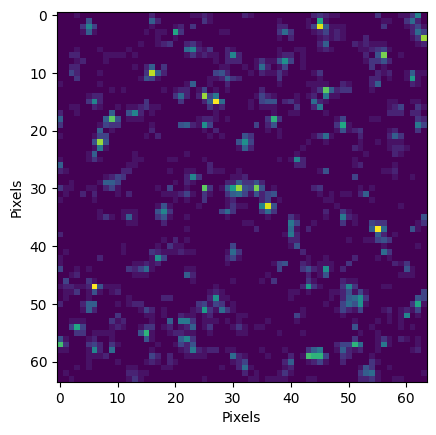

In [5]:
from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** exp_b
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a powerlaw with slope `exp_b` and min/max mean counts `s_min` and `s_max`. From:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))

fluxes, counts = simulate_sources(amp_b=200., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

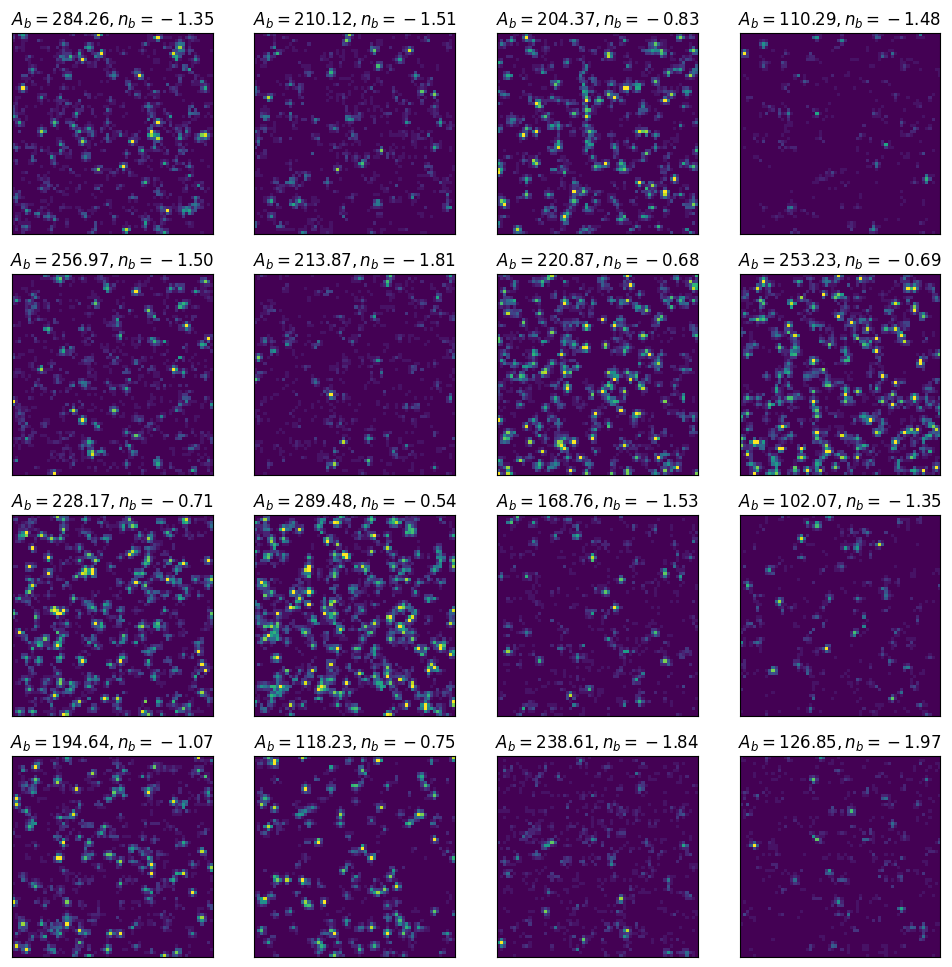

In [6]:
# Draw parameters from the prior
n_params = 16

amp_b_prior = (100., 300.)
exp_b_prior = (-2.0, -0.5)

amp_bs = np.random.uniform(amp_b_prior[0], amp_b_prior[1], n_params)
exp_bs = np.random.uniform(exp_b_prior[0], exp_b_prior[1], n_params)

# Plot the data samples on a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    fluxes, counts = simulate_sources(amp_b=amp_bs[i], exp_b=exp_bs[i])
    im = ax.imshow(counts, cmap='viridis', vmax=20)
    ax.set_title(f'$A_b={amp_bs[i]:.2f}, n_b={exp_bs[i]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Explicit likelihood

The (marginal) likelihood, which we would need to plug into something like MCMC, is computationally intractable! This is because it involves an integral over a cumbersome latent space, which consists of all possible number $n$ of sources and their positions $\{z\}=\{x, y\}_{i=1}^{n}$. Let's write this out formally:
$$p(x \mid \theta)=\sum_{n} \int \mathrm{d}^{n} \{z\}\, p\left(n \mid \theta\right) \prod_i^{n} p\left(z_{i} \mid \theta\right) \, p\left(x \mid \theta,\left\{z_{i}\right\}\right)$$

## Implicit inference: Neural posterior estimation (NPE)

Let's use neural posterior estimation with a normalizing flow again.

In [17]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


In [18]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Get a training sample:

In [19]:
n_train = 30_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 30000/30000 [00:19<00:00, 1558.89it/s]


In [20]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


Since we're working with images, use a simple convolutional neural network (CNN) as the feature extractor. The normalizing flow will be conditioned on the output of the CNN.

In [21]:
class CNN(nn.Module):
    """ Simple CNN feature extractor.
    """
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)  # Add channel dim
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x

In [22]:
npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([5.0771, 5.4279, 5.0963, 4.9637, 5.2412, 5.1640, 4.9681, 5.0138, 5.4917,
        5.2454, 5.5176, 5.1477, 5.0274, 5.1675, 5.3460, 4.9332, 5.5468, 5.3103,
        5.6053, 5.0777, 5.0708, 5.0141, 4.9440, 5.2335, 5.5046, 5.0096, 5.0460,
        4.9886, 5.4831, 5.1577, 5.2802, 5.1955, 5.2977, 5.0370, 5.4381, 4.9540,
        4.9300, 5.1522, 4.9924, 4.9758, 5.0134, 5.1280, 5.2867, 5.2683, 5.4912,
        5.0399, 4.9595, 5.0753, 5.1446, 5.4980, 4.9159, 5.2236, 5.0378, 5.1031,
        4.9471, 5.0890, 5.2765, 5.5386, 5.6025, 5.1160, 4.9168, 4.9750, 5.4407,
        5.3561], grad_fn=<NegBackward0>)

In [23]:
trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [39]:
npe = npe.eval()

Get a test map, extract features, condition normalizing flow, extract samples.

In [40]:
params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

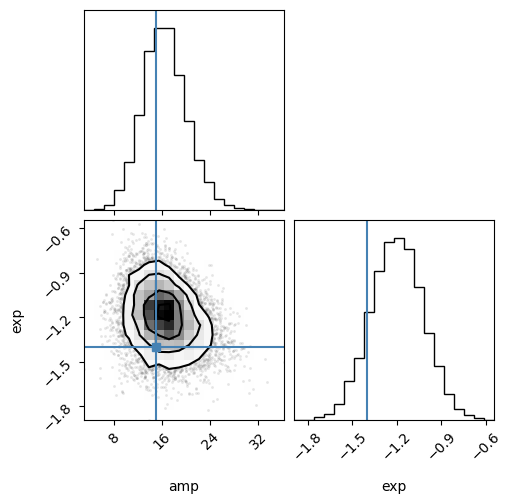

In [41]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

## Test of statistical coverage

<img src=./assets/coverage.png alt= “” width=800>

Figure from 2209.01845.

We can do some checks to make sure that our posterior has the correct statistical interpretation. In particular, let's test the posterior statistical coverage by evaluating how well the Highest Posterior Density (HPD) intervals capture the true parameter values.

The **Highest Posterior Density (HPD)** interval is a region in the parameter space that contains the most probable values for a given credible mass (e.g., 95% or 99%). In other words, it is the shortest interval that contains the specified credible mass of the posterior distribution. This is one of summarizing a posterior distribution.

**Nominal coverage** is the probability, or the proportion of the parameter space, that the HPD interval is intended to contain. For example, if the nominal coverage is 0.95, the HPD interval should theoretically contain the true parameter value 95% of the time.

**Empirical coverage** is the proportion of true parameter values that actually fall within the HPD interval, based on a set of test cases or simulations.

For a perfectly calibrated posterior estimator, empirical coverage = nominal coverage for all credibility levels.

In [42]:
n_test = 200  # How many test samples to draw for coverage test

# Get samples 
x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

# and featurize
context = npe.featurizer(x_test_norm)

# Get posterior for all samples together in a batch
samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9601/4001163492.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])


In [43]:
def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

(18.008186, 19.924797)

## **Exercise**: Implement the alogirth from lecture

This wont scale to high to high dimensions. But the one shown in lecture (slide 41) will. But we need the log probability. In this case, we have that. 

In [44]:
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

Text(0.5, 1.0, 'Coverage for exponent')

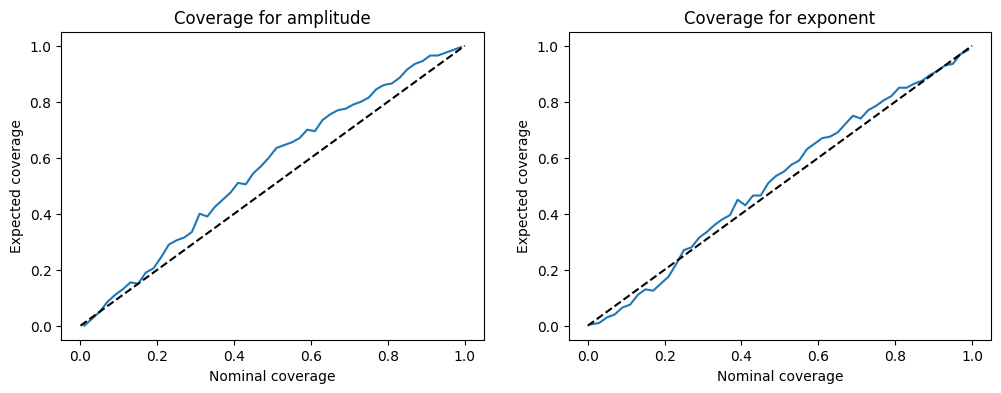

In [45]:
# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Expected coverage")
ax[0].set_title("Coverage for amplitude")



ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Expected coverage")
ax[1].set_title("Coverage for exponent")

# Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources

<img src=./assets/header.png alt= “” width=800>
